In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import itertools

from qiskit import transpile
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister
from qiskit import Aer, execute
from qiskit.tools.visualization import plot_histogram

from torch import optim

# qiskit AQUA 
from qiskit.aqua.components.optimizers import ADAM
from qiskit.aqua.components.uncertainty_models import UniformDistribution, UnivariateVariationalDistribution
from qiskit.aqua.components.variational_forms import RY
from qiskit.aqua.algorithms.adaptive import QGAN
from qiskit.aqua.components.neural_networks.quantum_generator import QuantumGenerator
from qiskit.aqua.components.neural_networks.numpy_discriminator import NumpyDiscriminator
from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.aqua.components.initial_states import Custom

In [2]:
alpha = 0.85
target_graph = np.array([[0, 1, 0, 1],
                                [0, 0, 1, 0],
                                [0, 1, 0, 1],
                                [0, 0, 1, 0]])

E = np.array([[1/4, 1/2, 0, 1/2],
                 [1/4, 0, 1/2, 0],
                 [1/4, 1/2, 0, 1/2],
                 [1/4, 0, 1/2, 0]])
# use google matrix
prob_dist = alpha*E + ((1-alpha)/4)*np.ones((4, 4))
init_state = 1/2*np.array([np.sqrt(prob_dist[j][i]) for i in range(4) for j in range(4)])

Check data format

<class 'numpy.ndarray'>
[16.31118818  5.40435698  1.05516279  0.65838793  1.98064093  2.67436482
  0.33089882  2.02580624  0.7496586   4.39062537  2.92572753  0.74328154
  2.1179795   0.71412844  4.79456168  9.53916789  4.43632501  5.94004227
  1.95683892  9.00374536  3.13348145  6.6516204   2.69048717  5.28185276
  1.35238523  0.61246999 13.17892725  0.45289256  3.25299314  3.1869025
  1.84733773  4.19182613  0.40210483  1.5997834   1.33612781  4.31497671
 10.01231161  4.14509004  3.39113816  7.44861624  1.75098364  1.81908797
  4.37806323  5.98997291  1.17243106  3.32975328  2.21186634  4.03988195
  9.77876387  7.77389924 10.11189991  0.51751312  2.70089176  2.22878466
  2.73131057  2.57268222  0.67968978  6.02504439  1.75276906  4.80297049
  7.60801233  1.10542253  3.2667717   0.92222525  4.73427102  3.18274565
  2.61913911  8.9149604  35.79086275  8.51371272  3.65002531 10.86513458
  0.62417724  1.9844724   2.77902882  8.17161004  4.96898418  0.60215068
  2.95597368  4.05281564  7.

(array([905.,  71.,  10.,   5.,   3.,   4.,   0.,   1.,   0.,   1.]),
 array([ 0.13487194,  9.93474614, 19.73462034, 29.53449454, 39.33436874,
        49.13424293, 58.93411713, 68.73399133, 78.53386553, 88.33373973,
        98.13361393]),
 <a list of 10 Patch objects>)

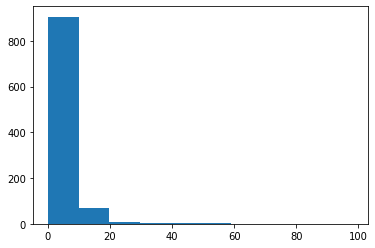

In [60]:
# Number training data samples
N = 1000 

# Load data samples from log-normal distribution with mean=1 and standard deviation=1
mu = 1
sigma = 1
real_data = np.random.lognormal(mean = mu, sigma=sigma, size=N)
# Set the data resolution
# Set upper and lower data values as list of k min/max data values [[min_0,max_0],...,[min_k-1,max_k-1]]
bounds = np.array([0.,3.]) 
# Set number of qubits per data dimension as list of k qubit values[#q_0,...,#q_k-1]
num_qubits = [2]
k = len(num_qubits)
print(real_data)
plt.hist(real_data)

## Not generalized 4node

In [41]:
# QGAN
# Set number of training epochs
# Note: The algorithm's runtime can be shortened by reducing the number of training epochs.
num_epochs = 3000
# Batch size
batch_size = 100

 # Initialize qGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)
qgan.seed = 1
# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(backend=Aer.get_backend('statevector_simulator'))

# Set entangler map
entangler_map = [[0, 1]]

# Set an initial state for the generator circuit
init_dist = UniformDistribution(sum(num_qubits), low=bounds[0], high=bounds[1])
print(init_dist.probabilities)
q = QuantumRegister(sum(num_qubits), name='q')
qc = QuantumCircuit(q)
init_dist.build(qc, q)
init_distribution = Custom(num_qubits=sum(num_qubits), circuit=qc)
var_form = RY(int(np.sum(num_qubits)), depth=1, initial_state = init_distribution, 
              entangler_map=entangler_map, entanglement_gate='cz')
# Set generator's initial parameters
init_params = aqua_globals.random.rand(var_form._num_parameters) * 2 * np.pi
# Set generator circuit
g_circuit = UnivariateVariationalDistribution(int(sum(num_qubits)), var_form, init_params,
                                              low=bounds[0], high=bounds[1])
# Set quantum generator
qgan.set_generator(generator_circuit=g_circuit)
# Set classical discriminator neural network
discriminator = NumpyDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)

[0.25 0.25 0.25 0.25]


In [42]:
# Run qGAN
qgan.run(quantum_instance)

{'params_d': array([ 0.13011988,  0.09450368,  0.58881671, ..., -0.06961767,
         0.18986893,  0.02677406]),
 'params_g': array([2.87781746, 4.79105796, 0.25649406, 1.64971143]),
 'loss_d': 0.6932,
 'loss_g': array([0.6903]),
 'rel_entr': 0.1928}

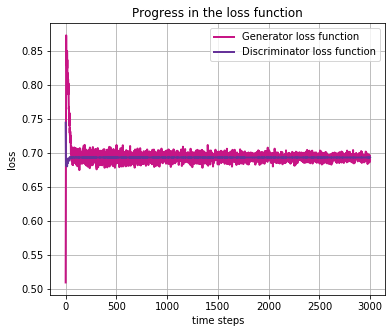

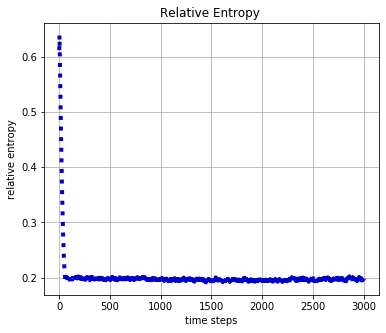

[0.21680790248021245, 0.2558065329548865, 0.2775587411992821, 0.24982682336561918]
[0. 1. 2. 3.]


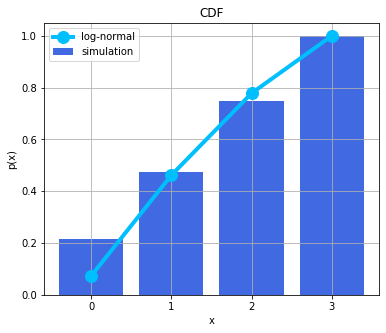

In [35]:
# Plot progress w.r.t the generator's and the discriminator's loss function
t_steps = np.arange(num_epochs)
plt.figure(figsize=(6,5))
plt.title("Progress in the loss function")
plt.plot(t_steps, qgan.g_loss, label = "Generator loss function", color = 'mediumvioletred', linewidth = 2)
plt.plot(t_steps, qgan.d_loss, label = "Discriminator loss function", color = 'rebeccapurple', linewidth = 2)
plt.grid()
plt.legend(loc = 'best')
plt.xlabel('time steps')
plt.ylabel('loss')
plt.show()


# Plot progress w.r.t relative entropy
plt.figure(figsize=(6,5))
plt.title("Relative Entropy ")
plt.plot(np.linspace(0, num_epochs, len(qgan.rel_entr)), qgan.rel_entr, color ='mediumblue', lw=4, ls=':')
plt.grid()
plt.xlabel('time steps')
plt.ylabel('relative entropy')
plt.show()

#Plot the PDF of the resulting distribution against the target distribution, i.e. log-normal
log_normal = np.random.lognormal(mean=1, sigma=1, size=100000)
log_normal = np.round(log_normal)
log_normal = log_normal[log_normal <= bounds[1]]
temp = []
for i in range(int(bounds[1]+1)):
    temp += [np.sum(log_normal==i)]
log_normal = np.array(temp / sum(temp))

plt.figure(figsize=(6,5))
plt.title("CDF")
samples_g, prob_g = qgan.generator.get_output(qgan.quantum_instance, shots=10000)
samples_g = np.array(samples_g)
samples_g = samples_g.flatten()
num_bins = len(prob_g)
print(prob_g)
print(samples_g)
plt.bar(samples_g,  np.cumsum(prob_g), color='royalblue', width= 0.8, label='simulation')
plt.plot( np.cumsum(log_normal),'-o', label='log-normal', color='deepskyblue', linewidth=4, markersize=12)
plt.xticks(np.arange(min(samples_g), max(samples_g)+1, 1.0))
plt.grid()
plt.xlabel('x')
plt.ylabel('p(x)')
plt.legend(loc='best')
plt.show()

In [44]:
print(len(qgan._ret['params_g']))
for i in qgan._ret['params_g']:
    print(i)
gp = qgan._ret['params_g']

4
2.8778174608770337
4.791057960972657
0.25649406246697887
1.649711432107711


In [52]:
q = QuantumRegister(2)
c = ClassicalRegister(2)
qc = QuantumCircuit(q, c)
qc.h(q)
qc.ry(gp[0], q[0])
qc.ry(gp[1], q[1])
qc.cz(q[0], q[1])
qc.ry(gp[2], q[0])
qc.ry(gp[3], q[1])

job = execute(qc, backend=Aer.get_backend('statevector_simulator'))
vec = job.result().get_statevector(qc)
print(vec)
qc.measure(q[0], c[1])
qc.measure(q[1], c[0])
shots = 10000
job = execute(qc, backend=Aer.get_backend('qasm_simulator'), shots=shots)
count = job.result().get_counts(qc)
bins = [format(i, "0%db"%num_qubits[0]) for i in range(2**num_qubits[0])]
pros = itertools.accumulate([count.get(i, 0)/shots for i in bins])
print(list(pros))

# plot_histogram(pros)

[ 0.46328459+0.j -0.50624677+0.j  0.53042258+0.j -0.49772832+0.j]
[0.2149, 0.49660000000000004, 0.7530000000000001, 1.0]


In [6]:
# Circuit
# Hardcoded now!
num_qubits = [2]
bins = [format(i, "0%db"%num_qubits[0]) for i in range(2**num_qubits[0])]
def four_node(step):
    rotation = np.radians(31.788)
    cq = QuantumRegister(2, 'control')
    tq = QuantumRegister(2, 'target')
    c = ClassicalRegister(2, 'classical')
    anc = QuantumRegister(2, 'ancilla')
    qc = QuantumCircuit(cq, tq, anc, c)
        
#     initialize with probability distribution matrix
    initial = 1/2*np.array([np.sqrt(prob_dist[j][i]) for i in range(4) for j in range(4)])
    qc.initialize(initial, [*cq, *tq])
    
    for t in range(step):
        # Ti operation
        qc.x(cq[1])
        qc.ccx(cq[0], cq[1], tq[1])
        qc.x(cq[1])
        qc.barrier()

        # Kdg operation
        qc.x(cq)
        qc.rccx(cq[0], cq[1], anc[0])
        qc.barrier()

        qc.ch(anc[0], tq[0])
        qc.ch(anc[0], tq[1])

        qc.x(anc[0])
        qc.cry(-rotation, anc[0], tq[1])
        qc.ch(anc[0], tq[0])
        qc.barrier()

        # D operation
        qc.x(tq)
        qc.cz(tq[0], tq[1])
        qc.x(tq)
        qc.barrier()

        # K operation
        qc.ch(anc[0], tq[0])
        qc.cry(rotation, anc[0], tq[1])
        qc.x(anc[0])
        qc.ch(anc[0], tq[1])
        qc.ch(anc[0], tq[0])

        qc.rccx(cq[0], cq[1], anc[0])
        qc.x(cq)
        qc.barrier()

    # Tidg operation
        qc.x(cq[1])
        qc.ccx(cq[0], cq[1], tq[1])
        qc.x(cq[1])
        qc.barrier()

#             swap
        qc.swap(tq[0], cq[0])
        qc.swap(tq[1], cq[1])
    qc.measure(tq, c)
    return qc

In [23]:
step = 1
qwqc = four_node(step)
shots = 10000
job = execute(qwqc, backend=Aer.get_backend("qasm_simulator"), shots=shots)
counts = job.result().get_counts(qwqc)
probs = np.array(([0] * counts.get('00'), [1]* counts.get('01'), [2] * counts.get('10'), [3] * counts.get('11')))
real_data = []
for i in probs:
    for j in i:
        real_data.append(j)

In [24]:
bounds = np.array([0.,3.]) 
# Set number of qubits per data dimension as list of k qubit values[#q_0,...,#q_k-1]
num_qubits = [2]
k = len(num_qubits)

In [25]:
# QGAN
# Set number of training epochs
# Note: The algorithm's runtime can be shortened by reducing the number of training epochs.
num_epochs = 3000
# Batch size
batch_size = 100

 # Initialize qGAN
qgan = QGAN(real_data, bounds, num_qubits, batch_size, num_epochs, snapshot_dir=None)
qgan.seed = 1
# Set quantum instance to run the quantum generator
quantum_instance = QuantumInstance(backend=Aer.get_backend('statevector_simulator'))

# Set entangler map
entangler_map = [[0, 1]]

# Set an initial state for the generator circuit
init_dist = UniformDistribution(sum(num_qubits), low=bounds[0], high=bounds[1])
print(init_dist.probabilities)

q = QuantumRegister(sum(num_qubits), name='q')
qc = QuantumCircuit(q)

init_dist.build(qc, q)
init_distribution = Custom(num_qubits=sum(num_qubits), circuit=qc)
var_form = RY(int(np.sum(num_qubits)), depth=1, initial_state = init_distribution, 
              entangler_map=entangler_map, entanglement_gate='cz')
# Set generator's initial parameters
init_params = aqua_globals.random.rand(var_form._num_parameters) * 2 * np.pi
# Set generator circuit
g_circuit = UnivariateVariationalDistribution(int(sum(num_qubits)), var_form, init_params,
                                              low=bounds[0], high=bounds[1])
# Set quantum generator
qgan.set_generator(generator_circuit=g_circuit)
# Set classical discriminator neural network
discriminator = NumpyDiscriminator(len(num_qubits))
qgan.set_discriminator(discriminator)

[0.25 0.25 0.25 0.25]


In [ ]:
# Run qGAN
qgan.run(quantum_instance)